In [48]:
# ============================================================
# Cell 1: Imports and global parameters
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # for 3D surface plots

plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["figure.dpi"] = 120

# RLC parameters
R = 10.0        # Ohm
L = 10e-3       # H
Cval = 100e-6   # F

# Fundamental frequency
f0 = 50.0       # Hz
omega0 = 2 * np.pi * f0
T0 = 1.0 / f0

# MNA matrices for series RLC (same structure as before)
C_mat = np.array([[L, 0.0],
                  [0.0, Cval]], dtype=float)

G_mat = np.array([[R, 1.0],
                  [-1.0, 0.0]], dtype=float)


In [49]:
# ============================================================
# Cell 2: Trapezoidal integrator for C x' + G x = b(t)
# ============================================================

def trapezoidal_mna(C, G, b_func, t_grid, x0):
    """
    Solve C x'(t) + G x(t) = b(t) using the trapezoidal rule.

    Parameters
    ----------
    C : (n, n) ndarray
        Capacitance/inductance matrix from MNA.
    G : (n, n) ndarray
        Conductance / static matrix from MNA.
    b_func : callable
        b_func(t) -> (n,) array, right-hand side (sources).
    t_grid : (N,) ndarray
        Time points (uniform step).
    x0 : (n,) ndarray
        Initial state x(t_0).

    Returns
    -------
    X : (N, n) ndarray
        State trajectory at each time step.
    Bvals : (N, n) ndarray
        b(t) evaluated at each time step.
    """
    t_grid = np.asarray(t_grid)
    dt = t_grid[1] - t_grid[0]
    n = C.shape[0]
    N = len(t_grid)

    X = np.zeros((N, n))
    Bvals = np.zeros((N, n))
    X[0] = x0

    C_dt = C / dt
    A_lhs = C_dt + 0.5 * G
    A_lhs_inv = np.linalg.inv(A_lhs)

    for k in range(N - 1):
        t_k = t_grid[k]
        t_k1 = t_grid[k + 1]
        b_k = np.asarray(b_func(t_k))
        b_k1 = np.asarray(b_func(t_k1))
        Bvals[k] = b_k

        rhs = (C_dt - 0.5 * G) @ X[k] + 0.5 * (b_k + b_k1)
        X[k + 1] = A_lhs_inv @ rhs

    Bvals[-1] = np.asarray(b_func(t_grid[-1]))
    return X, Bvals


In [50]:
# ============================================================
# Cell 3: Dynamic phasor (order k=1) and reconstruction
# ============================================================

def compute_dynamic_phasor(signal, t_grid, f0, periods_in_window=1):
    """
    Compute the first-order dynamic phasor X̃(t) of a real-valued signal x(t).

    X̃(t) ≈ (1/T) ∫_{t-T}^{t} x(τ) e^{-j 2π f0 τ} dτ,
    approximated with a sliding discrete window.

    Parameters
    ----------
    signal : (N,) ndarray
        Real-valued signal samples.
    t_grid : (N,) ndarray
        Sample times (uniform step).
    f0 : float
        Fundamental frequency [Hz].
    periods_in_window : int
        Number of fundamental periods in the integration window.

    Returns
    -------
    X_dyn : (N,) ndarray of complex
        Dynamic phasor at each time step (NaN for samples before window
        is fully available).
    """
    t_grid = np.asarray(t_grid)
    x = np.asarray(signal)
    dt = t_grid[1] - t_grid[0]

    T0 = 1.0 / f0
    window_length = int(round(periods_in_window * T0 / dt))
    if window_length < 2:
        raise ValueError("Window too short relative to dt.")

    N = len(t_grid)
    X_dyn = np.full(N, np.nan, dtype=complex)
    omega0 = 2 * np.pi * f0

    for k in range(window_length - 1, N):
        idx_start = k - window_length + 1
        idx_end = k + 1
        t_win = t_grid[idx_start:idx_end]
        x_win = x[idx_start:idx_end]
        kernel = np.exp(-1j * omega0 * t_win)
        integral_approx = np.sum(x_win * kernel) * dt
        T_window = t_win[-1] - t_win[0]
        X_dyn[k] = (1.0 / T_window) * integral_approx

    return X_dyn


def reconstruct_from_phasor(X_dyn, t_grid, f0):
    """
    Reconstruct the fundamental component from the dynamic phasor:
        x_dp(t) ≈ Re{ X̃(t) e^{j 2π f0 t} }

    Parameters
    ----------
    X_dyn : (N,) complex ndarray
        Dynamic phasor samples.
    t_grid : (N,) ndarray
        Time samples.
    f0 : float
        Fundamental frequency [Hz].

    Returns
    -------
    x_dp : (N,) ndarray
        Reconstructed real-valued fundamental component.
    """
    omega0 = 2 * np.pi * f0
    t_grid = np.asarray(t_grid)
    return np.real(X_dyn * np.exp(1j * omega0 * t_grid))


In [51]:
# ============================================================
# Cell 4: Error metric between EMT and dynamic phasor model
# ============================================================

def simulate_and_error(f_sw_ratio, duty,
                       t_end=0.1,
                       dt=2e-5,
                       V_amp=10.0):
    """
    Simulate the series RLC with a PWM-switched sinusoidal source and
    compute the RMS error between time-domain current and its
    dynamic-phasor-based reconstruction.

    Parameters
    ----------
    f_sw_ratio : float
        Switching frequency ratio f_sw / f0.
    duty : float
        Duty cycle of the PWM (0 < duty < 1).
    t_end : float
        Simulation end time [s].
    dt : float
        Time step [s].
    V_amp : float
        Amplitude of the sinusoidal carrier [V].

    Returns
    -------
    error : float
        Normalized RMS error over the last two fundamental periods.
        If the reference RMS is extremely small, returns np.nan.
    """
    f_sw = f_sw_ratio * f0

    # Time grid
    t = np.arange(0.0, t_end + dt, dt)

    # Define source with PWM gating
    def v_source(t_local):
        if duty <= 0.0:
            return 0.0
        T_sw = 1.0 / f_sw
        tau = t_local % T_sw
        s = 1.0 if tau < duty * T_sw else 0.0
        return s * V_amp * np.sin(2 * np.pi * f0 * t_local)

    def b_func(t_local):
        return np.array([v_source(t_local), 0.0])

    # Initial conditions
    x0 = np.array([0.0, 0.0])

    # Run trapezoidal simulation (EMT reference)
    X, Bvals = trapezoidal_mna(C_mat, G_mat, b_func, t, x0)
    i_L = X[:, 0]

    # Dynamic phasor of inductor current
    X_dyn = compute_dynamic_phasor(i_L, t, f0, periods_in_window=1)

    # Reconstruct fundamental
    i_L_dp = reconstruct_from_phasor(X_dyn, t, f0)

    # Select evaluation window: last two fundamental periods
    eval_start = t_end - 2 * T0
    mask_time = t >= eval_start

    # Ignore times where phasor is not defined (NaN)
    mask_valid = mask_time & (~np.isnan(X_dyn))

    if np.sum(mask_valid) < 10:
        return np.nan

    i_true = i_L[mask_valid]
    i_approx = i_L_dp[mask_valid]

    # RMS-based relative error
    rms_true = np.sqrt(np.mean(i_true**2))
    if rms_true < 1e-6:
        # Almost no current -> error not meaningful
        return np.nan

    rms_err = np.sqrt(np.mean((i_true - i_approx)**2))
    return rms_err / rms_true


In [52]:
# ============================================================
# Cell 5: Build 2D error map over (f_sw_ratio, duty)
# ============================================================

# Parameter grids
f_sw_ratios = np.linspace(2.0, 40.0, 10)   # from 2*f0 to 40*f0
duties = np.linspace(0.1, 0.9, 10)         # from 10% to 90%

F_grid, D_grid = np.meshgrid(f_sw_ratios, duties)  # for plotting
errors = np.zeros_like(F_grid)

# Compute error for each combination
for i in range(duties.size):
    for j in range(f_sw_ratios.size):
        duty = duties[i]
        ratio = f_sw_ratios[j]
        err = simulate_and_error(ratio, duty)
        errors[i, j] = err
        print(f"ratio={ratio:.1f}, duty={duty:.2f}, error={err:.3f}")

# Optional: mask insanely large errors (for color scale stability)
errors_clipped = np.clip(errors, 0.0, 1.0)  # e.g., max 100% error


ratio=2.0, duty=0.10, error=0.978
ratio=6.2, duty=0.10, error=0.934
ratio=10.4, duty=0.10, error=0.885
ratio=14.7, duty=0.10, error=0.818
ratio=18.9, duty=0.10, error=0.751
ratio=23.1, duty=0.10, error=0.705
ratio=27.3, duty=0.10, error=0.671
ratio=31.6, duty=0.10, error=0.645
ratio=35.8, duty=0.10, error=0.660
ratio=40.0, duty=0.10, error=0.608
ratio=2.0, duty=0.19, error=0.971
ratio=6.2, duty=0.19, error=0.925
ratio=10.4, duty=0.19, error=0.866
ratio=14.7, duty=0.19, error=0.793
ratio=18.9, duty=0.19, error=0.728
ratio=23.1, duty=0.19, error=0.678
ratio=27.3, duty=0.19, error=0.642
ratio=31.6, duty=0.19, error=0.615
ratio=35.8, duty=0.19, error=0.597
ratio=40.0, duty=0.19, error=0.582
ratio=2.0, duty=0.28, error=0.960
ratio=6.2, duty=0.28, error=0.914
ratio=10.4, duty=0.28, error=0.843
ratio=14.7, duty=0.28, error=0.766
ratio=18.9, duty=0.28, error=0.700
ratio=23.1, duty=0.28, error=0.651
ratio=27.3, duty=0.28, error=0.619
ratio=31.6, duty=0.28, error=0.598
ratio=35.8, duty=0.28, err

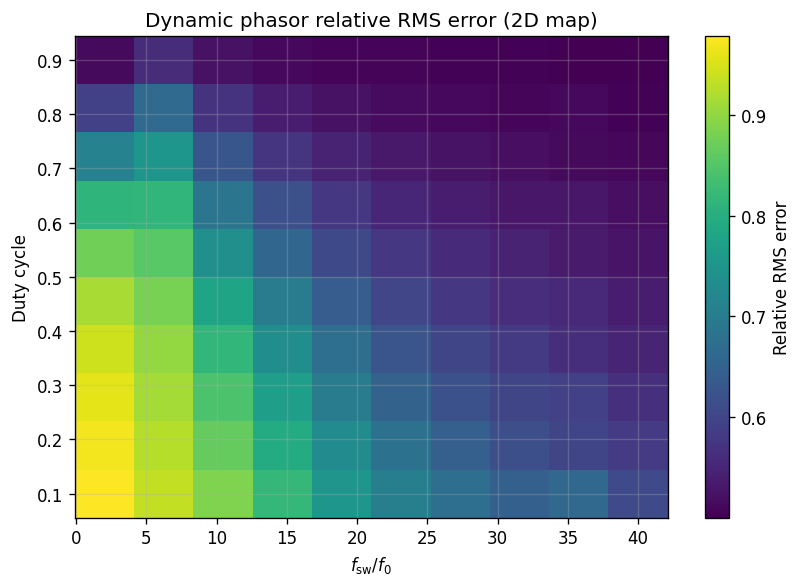

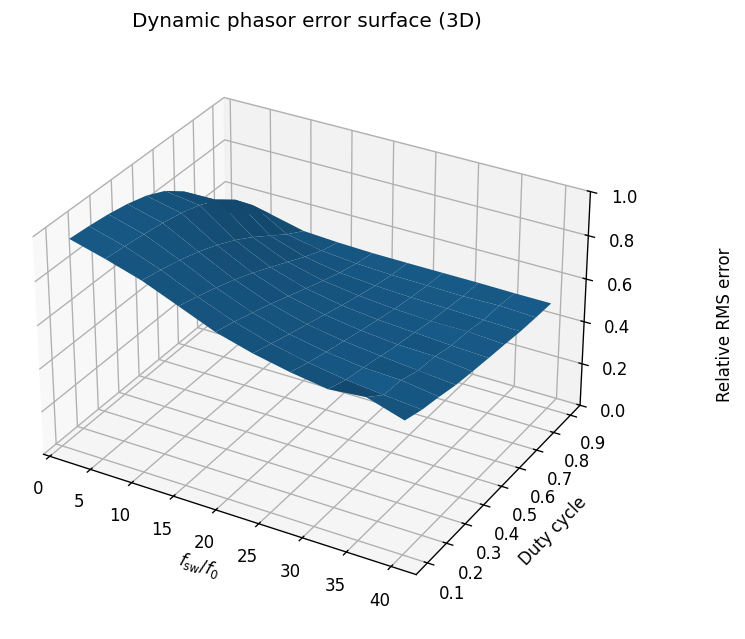

In [53]:
# ============================================================
# Cell 7: 3D surface plot of RMS error
# ============================================================

# 2D heatmap of RMS error (updated)
fig, ax = plt.subplots(figsize=(7, 5))
c = ax.pcolormesh(F_grid, D_grid, errors_clipped, shading='auto')
ax.set_xlabel(r"$f_{\mathrm{sw}} / f_0$")
ax.set_ylabel("Duty cycle")
ax.set_title("Dynamic phasor relative RMS error (2D map)")
cb = fig.colorbar(c, ax=ax)
cb.set_label("Relative RMS error")
ax.grid(True, alpha=0.3)
plt.tight_layout()   # <- avoid labels being cut
plt.show()
# ============================================================
# 3D surface plot of RMS error (updated)
# Assuming you have your data: F_grid, D_grid, errors_clipped ready

from mpl_toolkits.mplot3d import Axes3D

# (Assuming F_grid, D_grid, errors_clipped are already defined)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    F_grid, D_grid, errors_clipped,
    rstride=1, cstride=1,
    linewidth=0.3, antialiased=True
)

ax.set_xlabel(r"$f_{\mathrm{sw}} / f_0$")
ax.set_ylabel("Duty cycle")
ax.set_zlabel("")

ax.set_title("Dynamic phasor error surface (3D)")
ax.set_box_aspect((1.2, 1.0, 0.7))
ax.set_zlim(0.0, 1.0)

plt.subplots_adjust(left=0.08, right=0.85, bottom=0.08, top=0.9)

fig.text(
    0.90, 0.5,                  # (x, y) in figure coords
    "Relative RMS error",
    rotation=90,
    ha="center", va="center"
)

plt.show()



# Vary the number k

In [54]:
# ============================================================
# Multi-harmonic dynamic phasors (clean version)
# ============================================================

def compute_dynamic_phasors_multi(signal, t_grid, f0, k_list, periods_in_window=1):
    """
    Compute dynamic phasors X̃_k(t) for each k in k_list using
    the SAME fundamental period T0 (not k*f0).

        X̃_k(t) ≈ (1/T0) ∫_{t-T0}^{t} x(τ) e^{-j k ω0 τ} dτ

    Parameters
    ----------
    signal : (N,) ndarray
        Real-valued signal x(t).
    t_grid : (N,) ndarray
        Time samples (uniform step).
    f0 : float
        Fundamental frequency [Hz].
    k_list : list of int
        Harmonic indices (e.g. [1], [1, 3, 5]).
    periods_in_window : int
        Number of fundamental periods T0 in the integration window.

    Returns
    -------
    X_dict : dict
        Dictionary: k -> X̃_k(t) (each is (N,) complex array).
    """
    t_grid = np.asarray(t_grid)
    x = np.asarray(signal)
    dt = t_grid[1] - t_grid[0]

    T0 = 1.0 / f0
    window_length = int(round(periods_in_window * T0 / dt))
    if window_length < 2:
        raise ValueError("Window too short relative to dt.")

    N = len(t_grid)
    omega0 = 2 * np.pi * f0

    X_dict = {}
    for k in k_list:
        Xk = np.full(N, np.nan, dtype=complex)
        for n in range(window_length - 1, N):
            idx_start = n - window_length + 1
            idx_end = n + 1
            t_win = t_grid[idx_start:idx_end]
            x_win = x[idx_start:idx_end]
            kernel = np.exp(-1j * k * omega0 * t_win)
            integral_approx = np.sum(x_win * kernel) * dt
            T_window = t_win[-1] - t_win[0]
            Xk[n] = (1.0 / T_window) * integral_approx
        X_dict[k] = Xk

    return X_dict


def reconstruct_from_phasors_multi(X_dict, t_grid, f0):
    """
    Reconstruct real-valued signal from multiple dynamic phasors:

        x_dp(t) ≈ Re{ Σ_k X̃_k(t) e^{j k ω0 t} }.

    Parameters
    ----------
    X_dict : dict
        k -> X̃_k(t).
    t_grid : (N,) ndarray
        Time samples.
    f0 : float
        Fundamental frequency [Hz].

    Returns
    -------
    x_dp : (N,) ndarray
        Reconstructed real-valued signal.
    """
    t_grid = np.asarray(t_grid)
    omega0 = 2 * np.pi * f0
    x_rec = np.zeros_like(t_grid, dtype=float)

    for k, Xk in X_dict.items():
        x_rec += np.real(Xk * np.exp(1j * k * omega0 * t_grid))

    return x_rec


In [55]:
# ============================================================
# Error vs harmonic order for one (f_sw_ratio, duty)
# ============================================================

def simulate_multi_harmonic_error(f_sw_ratio, duty,
                                  max_k=9,
                                  t_end=0.1,
                                  dt=2e-5,
                                  V_amp=10.0,
                                  periods_in_window=1,
                                  eval_periods=2):
    """
    For a given (f_sw_ratio, duty), simulate EMT current and compute
    relative RMS error for increasing harmonic orders:
        {1}, {1,3}, {1,3,5}, ..., {1,3,...,max_k}.

    Returns
    -------
    ks_used : list of int
        Largest harmonic index in each set.
    errors : list of float
        Relative RMS error for each set.
    """
    f_sw = f_sw_ratio * f0
    t = np.arange(0.0, t_end + dt, dt)

    # PWM source
    def v_source(t_local):
        if duty <= 0.0:
            return 0.0
        T_sw = 1.0 / f_sw
        tau = t_local % T_sw
        s = 1.0 if tau < duty * T_sw else 0.0
        return s * V_amp * np.sin(2 * np.pi * f0 * t_local)

    def b_func(t_local):
        return np.array([v_source(t_local), 0.0])

    x0 = np.array([0.0, 0.0])
    X, Bvals = trapezoidal_mna(C_mat, G_mat, b_func, t, x0)
    i_true = X[:, 0]

    # all odd harmonics up to max_k
    k_all = list(range(1, max_k + 1, 2))
    X_dict_all = compute_dynamic_phasors_multi(
        i_true, t, f0, k_all, periods_in_window=periods_in_window
    )

    # evaluation window (last eval_periods periods)
    eval_start = t_end - eval_periods * (1.0 / f0)
    mask_time = t >= eval_start

    ks_used = []
    errors = []

    for k_max in k_all:
        current_ks = [k for k in k_all if k <= k_max]

        # sub-dictionary with current harmonics
        X_sub = {k: X_dict_all[k] for k in current_ks}
        i_dp = reconstruct_from_phasors_multi(X_sub, t, f0)

        # valid points: inside eval window and all phasors defined
        valid = mask_time.copy()
        for k in current_ks:
            valid &= ~np.isnan(X_sub[k])

        if np.sum(valid) < 10:
            ks_used.append(k_max)
            errors.append(np.nan)
            continue

        i_ref = i_true[valid]
        i_approx = i_dp[valid]

        rms_ref = np.sqrt(np.mean(i_ref**2))
        if rms_ref < 1e-8:
            ks_used.append(k_max)
            errors.append(np.nan)
            continue

        rms_err = np.sqrt(np.mean((i_ref - i_approx)**2))
        rel_err = rms_err / rms_ref

        ks_used.append(k_max)
        errors.append(rel_err)

    return ks_used, errors


In [56]:
# ============================================================
# K_opt map over (f_sw_ratio, duty)
# ============================================================

# Parameter grids
f_sw_ratios_m = np.linspace(2.0, 20.0, 6)   # e.g. 2, 6, 10, 14, 18, 20
duties_m      = np.linspace(0.2, 0.8, 7)    # 0.2 ... 0.8

F_grid_m, D_grid_m = np.meshgrid(f_sw_ratios_m, duties_m)

# Grids to store:
#  - BestErr_grid: minimum relative RMS error for each operating point
#  - K_best_grid : harmonic order that gives this minimum error
BestErr_grid = np.full_like(F_grid_m, np.nan, dtype=float)
K_best_grid  = np.full_like(F_grid_m, np.nan, dtype=float)

max_k = 21   # highest odd harmonic to consider

for i, duty in enumerate(duties_m):
    for j, ratio in enumerate(f_sw_ratios_m):

        # Compute error for harmonic sets {1}, {1,3}, ... up to max_k
        ks, errs = simulate_multi_harmonic_error(
            f_sw_ratio=ratio,
            duty=duty,
            max_k=max_k,
            t_end=0.1,
            dt=2e-5,
            V_amp=10.0,
            periods_in_window=1,
            eval_periods=2
        )

        ks   = np.array(ks)
        errs = np.array(errs)

        # Keep only valid entries (where error was computed)
        valid = ~np.isnan(errs)

        if np.any(valid):
            # Index of the minimum error among valid entries
            idx_min = np.nanargmin(errs)
            BestErr_grid[i, j] = errs[idx_min]
            K_best_grid[i, j]  = ks[idx_min]
            print(f"ratio={ratio:.1f}, duty={duty:.2f}, "
                  f"best_k={K_best_grid[i,j]}, best_err={BestErr_grid[i,j]:.3f}")
        else:
            # No valid error (should be rare)
            BestErr_grid[i, j] = np.nan
            K_best_grid[i, j]  = np.nan
            print(f"ratio={ratio:.1f}, duty={duty:.2f}, no valid error")



ratio=2.0, duty=0.20, best_k=21.0, best_err=0.500
ratio=5.6, duty=0.20, best_k=9.0, best_err=0.906
ratio=9.2, duty=0.20, best_k=7.0, best_err=0.813
ratio=12.8, duty=0.20, best_k=1.0, best_err=0.828
ratio=16.4, duty=0.20, best_k=13.0, best_err=0.734
ratio=20.0, duty=0.20, best_k=21.0, best_err=0.541
ratio=2.0, duty=0.30, best_k=21.0, best_err=0.500
ratio=5.6, duty=0.30, best_k=21.0, best_err=0.896
ratio=9.2, duty=0.30, best_k=7.0, best_err=0.788
ratio=12.8, duty=0.30, best_k=1.0, best_err=0.797
ratio=16.4, duty=0.30, best_k=13.0, best_err=0.703
ratio=20.0, duty=0.30, best_k=21.0, best_err=0.516
ratio=2.0, duty=0.40, best_k=21.0, best_err=0.500
ratio=5.6, duty=0.40, best_k=21.0, best_err=0.881
ratio=9.2, duty=0.40, best_k=7.0, best_err=0.761
ratio=12.8, duty=0.40, best_k=1.0, best_err=0.760
ratio=16.4, duty=0.40, best_k=13.0, best_err=0.668
ratio=20.0, duty=0.40, best_k=21.0, best_err=0.505
ratio=2.0, duty=0.50, best_k=21.0, best_err=0.500
ratio=5.6, duty=0.50, best_k=21.0, best_err=0.86

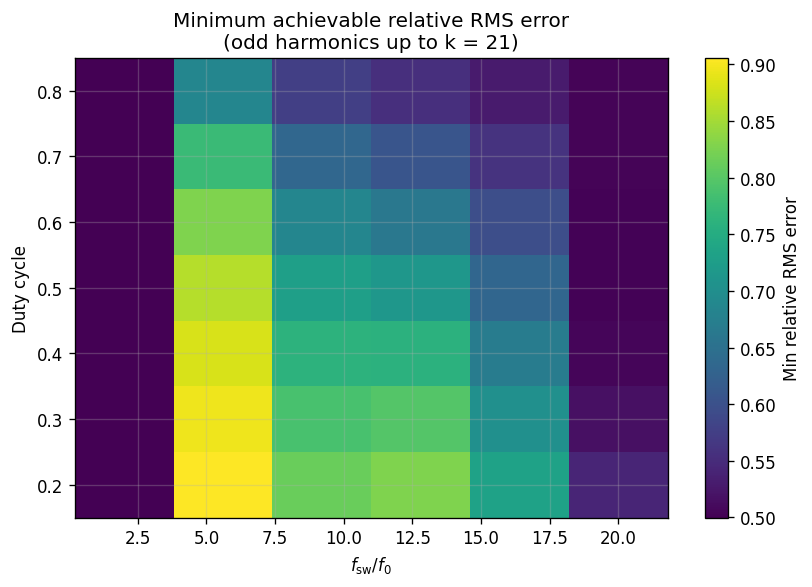

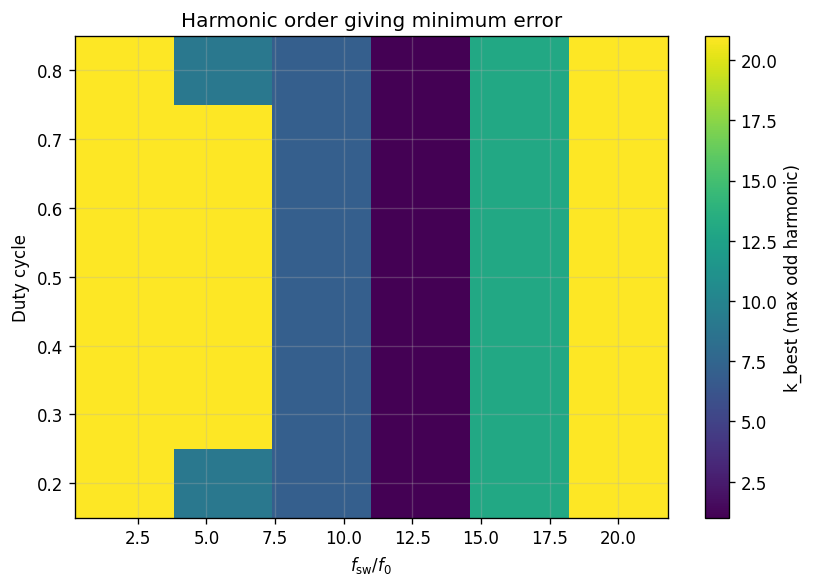

In [57]:
# ============================================================
# Cell A4: Plot K_opt map (2D)
# ============================================================

# Heatmap of minimum achievable error
fig, ax = plt.subplots(figsize=(7, 5))
c = ax.pcolormesh(F_grid_m, D_grid_m, BestErr_grid, shading='auto')
ax.set_xlabel(r"$f_{\mathrm{sw}} / f_0$")
ax.set_ylabel("Duty cycle")
ax.set_title("Minimum achievable relative RMS error\n(odd harmonics up to k = 21)")
cb = fig.colorbar(c, ax=ax)
cb.set_label("Min relative RMS error")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# (Optional) heatmap of best k
fig, ax = plt.subplots(figsize=(7, 5))
c = ax.pcolormesh(F_grid_m, D_grid_m, K_best_grid, shading='auto')
ax.set_xlabel(r"$f_{\mathrm{sw}} / f_0$")
ax.set_ylabel("Duty cycle")
ax.set_title("Harmonic order giving minimum error")
cb = fig.colorbar(c, ax=ax)
cb.set_label("k_best (max odd harmonic)")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
# ============================================================


# Hybrid EMT / Phasor Rule

In [58]:
# ============================================================
# Cell B1: Hybrid indicator and mode tagging
# ============================================================

def hybrid_indicator_and_modes(f_sw_ratio, duty,
                               t_end=0.2,
                               dt=2e-5,
                               V_amp=10.0,
                               periods_in_window=1,
                               window_periods=1,
                               err_threshold=0.10):
    """
    For a given (f_sw_ratio, duty), compute:
      - EMT reference current
      - fundamental dynamic phasor approximation
      - local relative RMS error as indicator
      - mode tag: 'DP' (phasor) or 'EMT'

    Parameters
    ----------
    f_sw_ratio : float
        Switching frequency ratio f_sw / f0.
    duty : float
        PWM duty cycle.
    t_end, dt, V_amp : simulation params.
    periods_in_window : int
        Window length for computing dynamic phasor.
    window_periods : int
        Length of local window (in fundamental periods) for the error indicator.
    err_threshold : float
        If local relative RMS error <= threshold -> 'DP', else 'EMT'.

    Returns
    -------
    t : (N,) ndarray
        Time samples.
    i_true : (N,) ndarray
        EMT reference inductor current.
    i_dp : (N,) ndarray
        Dynamic phasor reconstructed current.
    indicator : (N,) ndarray
        Local relative RMS error (NaN where not defined).
    modes : (N,) ndarray of dtype '<U3'
        'DP' or 'EMT' at each time sample.
    """
    f_sw = f_sw_ratio * f0
    t = np.arange(0.0, t_end + dt, dt)

    def v_source(t_local):
        if duty <= 0.0:
            return 0.0
        T_sw = 1.0 / f_sw
        tau = t_local % T_sw
        s = 1.0 if tau < duty * T_sw else 0.0
        return s * V_amp * np.sin(2 * np.pi * f0 * t_local)

    def b_func(t_local):
        return np.array([v_source(t_local), 0.0])

    x0 = np.array([0.0, 0.0])
    X, Bvals = trapezoidal_mna(C_mat, G_mat, b_func, t, x0)
    i_true = X[:, 0]

    # fundamental dynamic phasor + reconstruction
    X_dyn = compute_dynamic_phasor(i_true, t, f0, periods_in_window=periods_in_window)
    i_dp = reconstruct_from_phasor(X_dyn, t, f0)

    # local RMS error indicator
    dt_local = t[1] - t[0]
    T0 = 1.0 / f0
    win_len = int(round(window_periods * T0 / dt_local))
    N = len(t)

    indicator = np.full(N, np.nan)
    modes = np.full(N, 'EMT', dtype='<U3')   # default: EMT

    for k in range(win_len - 1, N):
        # ignore if phasor not yet defined
        if np.isnan(X_dyn[k]):
            continue

        idx_start = k - win_len + 1
        idx_end = k + 1

        i_ref_win = i_true[idx_start:idx_end]
        i_dp_win = i_dp[idx_start:idx_end]

        rms_ref = np.sqrt(np.mean(i_ref_win**2))
        if rms_ref < 1e-8:
            continue

        rms_err = np.sqrt(np.mean((i_ref_win - i_dp_win)**2))
        rel_err = rms_err / rms_ref
        indicator[k] = rel_err

        # mode decision
        modes[k] = 'DP' if rel_err <= err_threshold else 'EMT'

    return t, i_true, i_dp, indicator, modes


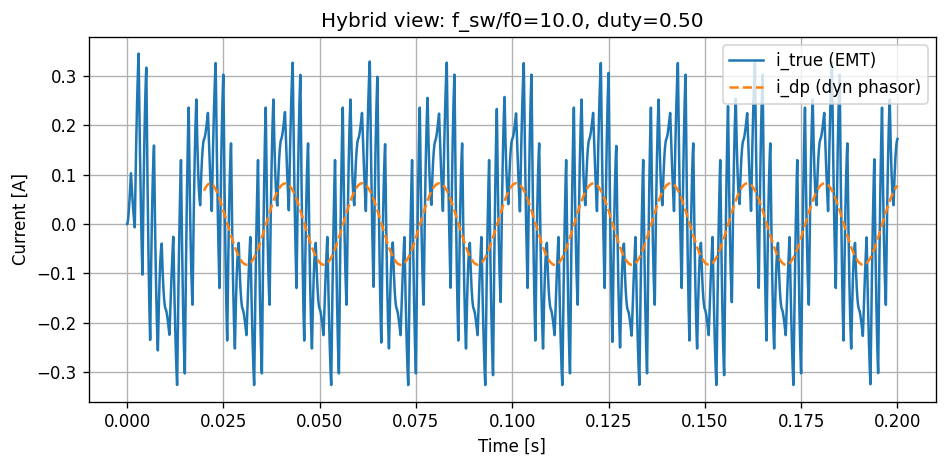

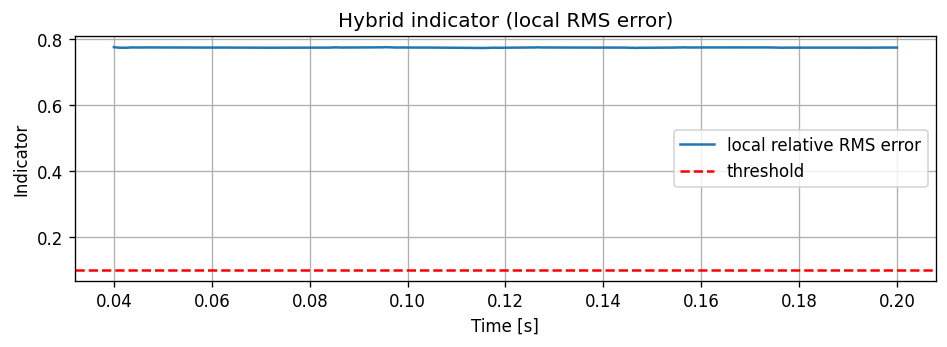

In [59]:
# ============================================================
# Cell B2: Example hybrid plot for one operating point
# ============================================================

# Choose one operating point to visualise
ratio_example = 10.0   # f_sw / f0
duty_example = 0.5

t_h, i_true_h, i_dp_h, ind_h, modes_h = hybrid_indicator_and_modes(
    ratio_example, duty_example,
    t_end=0.2,
    dt=2e-5,
    V_amp=10.0,
    periods_in_window=1,
    window_periods=1,
    err_threshold=0.10   # 10 % threshold
)

# Plot currents
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(t_h, i_true_h, label="i_true (EMT)")
ax.plot(t_h, i_dp_h, label="i_dp (dyn phasor)", linestyle="--")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Current [A]")
ax.set_title(f"Hybrid view: f_sw/f0={ratio_example:.1f}, duty={duty_example:.2f}")
ax.grid(True)
ax.legend(loc="upper right")

# Shade background according to mode ('DP' vs 'EMT')
# We'll just overlay a semi-transparent color for DP segments.
in_dp = (modes_h == 'DP')
ax.fill_between(t_h, ax.get_ylim()[0], ax.get_ylim()[1],
                where=in_dp,
                color="green", alpha=0.1,
                transform=ax.get_xaxis_transform(),
                label=None)

plt.tight_layout()
plt.show()

# Plot indicator
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(t_h, ind_h, label="local relative RMS error")
ax.axhline(0.10, color="red", linestyle="--", label="threshold")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Indicator")
ax.set_title("Hybrid indicator (local RMS error)")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


In [60]:
# ============================================================
# Fundamental reference phasor from EMT waveform
# ============================================================

import numpy as np

def compute_reference_fundamental(signal, t_grid, f0, n_periods=2):
    """
    Compute a reference fundamental phasor from an EMT waveform by
    integrating over the last n_periods of the fundamental frequency.

    X_ref = (1/T_eval) ∫ x(t) e^{-j ω0 t} dt

    Parameters
    ----------
    signal : (N,) ndarray
        Real-valued EMT waveform x(t).
    t_grid : (N,) ndarray
        Time samples (uniform step).
    f0 : float
        Fundamental frequency [Hz].
    n_periods : int
        Number of fundamental periods used for the integration window.

    Returns
    -------
    X_ref : complex
        Reference fundamental phasor.
    t_start, t_end : float
        Time interval used for the integration (for information).
    """
    t_grid = np.asarray(t_grid)
    x = np.asarray(signal)
    dt = t_grid[1] - t_grid[0]
    T0 = 1.0 / f0

    T_eval = n_periods * T0
    t_end = t_grid[-1]
    t_start = t_end - T_eval

    # mask for the evaluation window
    mask = t_grid >= t_start
    t_win = t_grid[mask]
    x_win = x[mask]

    omega0 = 2 * np.pi * f0
    kernel = np.exp(-1j * omega0 * t_win)

    integral = np.sum(x_win * kernel) * dt
    X_ref = integral / T_eval

    return X_ref, t_start, t_end


In [61]:
# ============================================================
# Fundamental magnitude/phase error for one operating point
# ============================================================

def fundamental_error_for_point(f_sw_ratio, duty,
                                t_end=0.2,
                                dt=2e-5,
                                V_amp=10.0,
                                periods_in_window=1,
                                n_periods_ref=2):
    """
    For a given (f_sw_ratio, duty), compute:
      - EMT inductor current i_true(t)
      - dynamic phasor I_dyn(t)
      - reference fundamental phasor I_ref
      - magnitude and phase error between I_dyn (at final time) and I_ref.

    Returns
    -------
    mag_err : float
        Relative magnitude error: | |I_dyn| - |I_ref| | / |I_ref|.
    phase_err_deg : float
        Phase error in degrees, wrapped to [-180, 180].
    """
    f_sw = f_sw_ratio * f0
    t = np.arange(0.0, t_end + dt, dt)

    # PWM source definition
    def v_source(t_local):
        if duty <= 0.0:
            return 0.0
        T_sw = 1.0 / f_sw
        tau = t_local % T_sw
        s = 1.0 if tau < duty * T_sw else 0.0
        return s * V_amp * np.sin(2 * np.pi * f0 * t_local)

    def b_func(t_local):
        return np.array([v_source(t_local), 0.0])

    x0 = np.array([0.0, 0.0])
    X, Bvals = trapezoidal_mna(C_mat, G_mat, b_func, t, x0)
    i_true = X[:, 0]

    # Dynamic phasor from EMT waveform
    I_dyn = compute_dynamic_phasor(i_true, t, f0,
                                   periods_in_window=periods_in_window)

    # Dynamic phasor at final time (where it is defined)
    idx_last = np.where(~np.isnan(I_dyn))[0]
    if len(idx_last) == 0:
        return np.nan, np.nan
    idx_last = idx_last[-1]
    I_dyn_last = I_dyn[idx_last]

    # Reference phasor using last n_periods of EMT current
    I_ref, t_s, t_e = compute_reference_fundamental(
        i_true, t, f0, n_periods=n_periods_ref
    )

    mag_ref = np.abs(I_ref)
    mag_dyn = np.abs(I_dyn_last)

    if mag_ref < 1e-9:
        return np.nan, np.nan

    mag_err = np.abs(mag_dyn - mag_ref) / mag_ref

    # Phase error (deg), wrapped
    phase_ref = np.angle(I_ref, deg=True)
    phase_dyn = np.angle(I_dyn_last, deg=True)
    phase_err = phase_dyn - phase_ref
    # wrap to [-180, 180]
    phase_err = (phase_err + 180.0) % 360.0 - 180.0

    return mag_err, phase_err


ratio=2.0, duty=0.20, mag_err=0.001, ph_err=0.00 deg
ratio=5.6, duty=0.20, mag_err=0.081, ph_err=-1.03 deg
ratio=9.2, duty=0.20, mag_err=0.009, ph_err=0.13 deg
ratio=12.8, duty=0.20, mag_err=0.003, ph_err=-0.18 deg
ratio=16.4, duty=0.20, mag_err=0.014, ph_err=-0.05 deg
ratio=20.0, duty=0.20, mag_err=0.022, ph_err=-0.30 deg
ratio=2.0, duty=0.30, mag_err=0.001, ph_err=-0.00 deg
ratio=5.6, duty=0.30, mag_err=0.030, ph_err=-1.80 deg
ratio=9.2, duty=0.30, mag_err=0.013, ph_err=0.06 deg
ratio=12.8, duty=0.30, mag_err=0.001, ph_err=-0.52 deg
ratio=16.4, duty=0.30, mag_err=0.016, ph_err=-0.22 deg
ratio=20.0, duty=0.30, mag_err=0.000, ph_err=-0.80 deg
ratio=2.0, duty=0.40, mag_err=0.001, ph_err=-0.01 deg
ratio=5.6, duty=0.40, mag_err=0.014, ph_err=-2.41 deg
ratio=9.2, duty=0.40, mag_err=0.009, ph_err=-0.05 deg
ratio=12.8, duty=0.40, mag_err=0.007, ph_err=-0.45 deg
ratio=16.4, duty=0.40, mag_err=0.015, ph_err=-0.07 deg
ratio=20.0, duty=0.40, mag_err=0.002, ph_err=-0.06 deg
ratio=2.0, duty=0.50, 

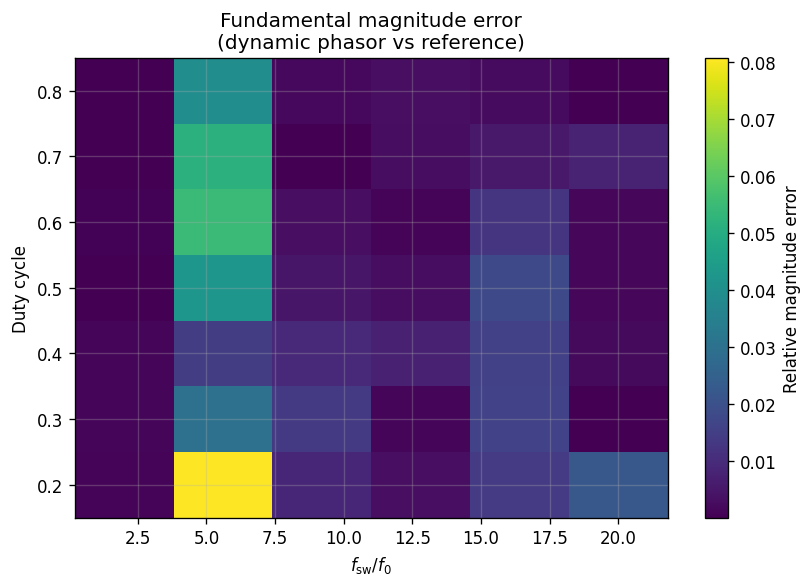

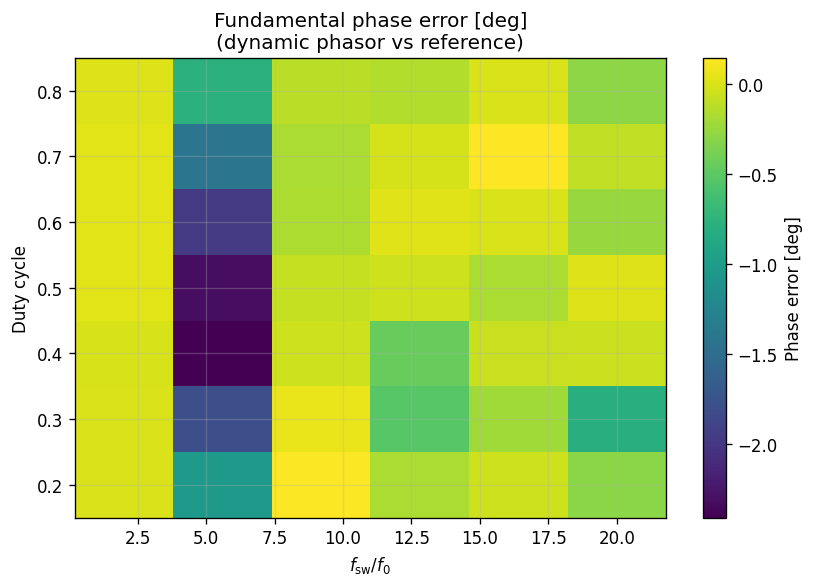

In [62]:
# ============================================================
# 2D maps of fundamental magnitude and phase error
# ============================================================

f_sw_ratios_f = np.linspace(2.0, 20.0, 6)
duties_f      = np.linspace(0.2, 0.8, 7)

F_grid_f, D_grid_f = np.meshgrid(f_sw_ratios_f, duties_f)
MagErr_grid  = np.full_like(F_grid_f, np.nan, dtype=float)
PhaseErr_grid = np.full_like(F_grid_f, np.nan, dtype=float)

for i, duty in enumerate(duties_f):
    for j, ratio in enumerate(f_sw_ratios_f):
        mag_err, ph_err = fundamental_error_for_point(
            f_sw_ratio=ratio,
            duty=duty,
            t_end=0.2,
            dt=2e-5,
            V_amp=10.0,
            periods_in_window=1,
            n_periods_ref=3
        )
        MagErr_grid[i, j]   = mag_err
        PhaseErr_grid[i, j] = ph_err
        print(f"ratio={ratio:.1f}, duty={duty:.2f}, "
              f"mag_err={mag_err:.3f}, ph_err={ph_err:.2f} deg")

import matplotlib.pyplot as plt

# Magnitude error heatmap
fig, ax = plt.subplots(figsize=(7, 5))
c = ax.pcolormesh(F_grid_f, D_grid_f, MagErr_grid, shading='auto')
ax.set_xlabel(r"$f_{\mathrm{sw}} / f_0$")
ax.set_ylabel("Duty cycle")
ax.set_title("Fundamental magnitude error\n(dynamic phasor vs reference)")
cb = fig.colorbar(c, ax=ax)
cb.set_label("Relative magnitude error")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Phase error heatmap
fig, ax = plt.subplots(figsize=(7, 5))
c = ax.pcolormesh(F_grid_f, D_grid_f, PhaseErr_grid, shading='auto')
ax.set_xlabel(r"$f_{\mathrm{sw}} / f_0$")
ax.set_ylabel("Duty cycle")
ax.set_title("Fundamental phase error [deg]\n(dynamic phasor vs reference)")
cb = fig.colorbar(c, ax=ax)
cb.set_label("Phase error [deg]")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [63]:
# ============================================================
# Hybrid indicator and mode tagging (from before, compact)
# ============================================================

def hybrid_indicator_and_modes(f_sw_ratio, duty,
                               t_end=0.2,
                               dt=2e-5,
                               V_amp=10.0,
                               periods_in_window=1,
                               window_periods=1,
                               err_threshold=0.10):
    """
    Compute EMT current, dynamic-phasor approximation, a local
    relative RMS error indicator, and mode tags ('DP' or 'EMT').

    Returns
    -------
    t : (N,) ndarray
    i_true : (N,) ndarray
    i_dp : (N,) ndarray
    indicator : (N,) ndarray
    modes : (N,) ndarray of strings 'DP' or 'EMT'
    """
    f_sw = f_sw_ratio * f0
    t = np.arange(0.0, t_end + dt, dt)

    def v_source(t_local):
        if duty <= 0.0:
            return 0.0
        T_sw = 1.0 / f_sw
        tau = t_local % T_sw
        s = 1.0 if tau < duty * T_sw else 0.0
        return s * V_amp * np.sin(2 * np.pi * f0 * t_local)

    def b_func(t_local):
        return np.array([v_source(t_local), 0.0])

    x0 = np.array([0.0, 0.0])
    X, Bvals = trapezoidal_mna(C_mat, G_mat, b_func, t, x0)
    i_true = X[:, 0]

    # dynamic phasor from EMT waveform
    I_dyn = compute_dynamic_phasor(i_true, t, f0,
                                   periods_in_window=periods_in_window)
    i_dp = reconstruct_from_phasor(I_dyn, t, f0)

    dt_local = t[1] - t[0]
    T0 = 1.0 / f0
    win_len = int(round(window_periods * T0 / dt_local))
    N = len(t)

    indicator = np.full(N, np.nan)
    modes = np.full(N, 'EMT', dtype='<U3')

    for k in range(win_len - 1, N):
        if np.isnan(I_dyn[k]):
            continue

        idx_start = k - win_len + 1
        idx_end = k + 1

        i_ref_win = i_true[idx_start:idx_end]
        i_dp_win  = i_dp[idx_start:idx_end]

        rms_ref = np.sqrt(np.mean(i_ref_win**2))
        if rms_ref < 1e-8:
            continue

        rms_err = np.sqrt(np.mean((i_ref_win - i_dp_win)**2))
        rel_err = rms_err / rms_ref
        indicator[k] = rel_err
        modes[k] = 'DP' if rel_err <= err_threshold else 'EMT'

    return t, i_true, i_dp, indicator, modes


ratio=2.0, duty=0.20, DP fraction=0.000
ratio=5.6, duty=0.20, DP fraction=0.000
ratio=9.2, duty=0.20, DP fraction=0.000
ratio=12.8, duty=0.20, DP fraction=0.000
ratio=16.4, duty=0.20, DP fraction=0.000
ratio=20.0, duty=0.20, DP fraction=0.000
ratio=2.0, duty=0.30, DP fraction=0.000
ratio=5.6, duty=0.30, DP fraction=0.000
ratio=9.2, duty=0.30, DP fraction=0.000
ratio=12.8, duty=0.30, DP fraction=0.000
ratio=16.4, duty=0.30, DP fraction=0.000
ratio=20.0, duty=0.30, DP fraction=0.000
ratio=2.0, duty=0.40, DP fraction=0.000
ratio=5.6, duty=0.40, DP fraction=0.000
ratio=9.2, duty=0.40, DP fraction=0.000
ratio=12.8, duty=0.40, DP fraction=0.000
ratio=16.4, duty=0.40, DP fraction=0.000
ratio=20.0, duty=0.40, DP fraction=0.000
ratio=2.0, duty=0.50, DP fraction=0.000
ratio=5.6, duty=0.50, DP fraction=0.000
ratio=9.2, duty=0.50, DP fraction=0.000
ratio=12.8, duty=0.50, DP fraction=0.000
ratio=16.4, duty=0.50, DP fraction=0.000
ratio=20.0, duty=0.50, DP fraction=0.000
ratio=2.0, duty=0.60, DP fra

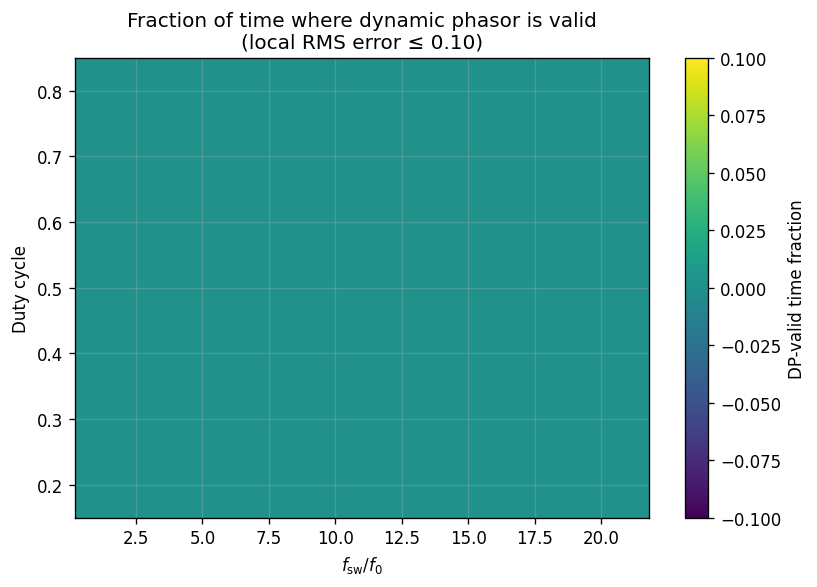

In [64]:
# ============================================================
# Map of DP-mode time fraction over (f_sw_ratio, duty)
# ============================================================

f_sw_ratios_h = np.linspace(2.0, 20.0, 6)
duties_h      = np.linspace(0.2, 0.8, 7)

F_grid_h, D_grid_h = np.meshgrid(f_sw_ratios_h, duties_h)
DPfrac_grid = np.full_like(F_grid_h, np.nan, dtype=float)

err_threshold = 0.10   # 10% local RMS error threshold

for i, duty in enumerate(duties_h):
    for j, ratio in enumerate(f_sw_ratios_h):

        t_h, i_true_h, i_dp_h, ind_h, modes_h = hybrid_indicator_and_modes(
            f_sw_ratio=ratio,
            duty=duty,
            t_end=0.2,
            dt=2e-5,
            V_amp=10.0,
            periods_in_window=1,
            window_periods=1,
            err_threshold=err_threshold
        )

        valid = ~np.isnan(ind_h)
        if np.sum(valid) == 0:
            DPfrac_grid[i, j] = np.nan
            continue

        dp_fraction = np.mean(modes_h[valid] == 'DP')
        DPfrac_grid[i, j] = dp_fraction

        print(f"ratio={ratio:.1f}, duty={duty:.2f}, "
              f"DP fraction={dp_fraction:.3f}")

# Plot heatmap
fig, ax = plt.subplots(figsize=(7, 5))
c = ax.pcolormesh(F_grid_h, D_grid_h, DPfrac_grid, shading='auto')
ax.set_xlabel(r"$f_{\mathrm{sw}} / f_0$")
ax.set_ylabel("Duty cycle")
ax.set_title(f"Fraction of time where dynamic phasor is valid\n"
             f"(local RMS error ≤ {err_threshold:.2f})")
cb = fig.colorbar(c, ax=ax)
cb.set_label("DP-valid time fraction")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
